Supervised ML approaches to explore human melanoma gene expression datasets - code adapted from the Fred Hutch PanCancer bootcamp (https://github.com/fredhutchio/practice-machine-learning)

Using bulk transcriptomics data to predict whether or not samples are derived from primary tumors or metastases. 

Datasets were downloaded and pre-processed using TCGAbiolinks package in R.  

Load libraries 

In [108]:
# Data Manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats
import statsmodels.api as sm

# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# visualization
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the plot style
plt.style.use('ggplot')
%matplotlib inline

Define function to read in expression data and metadata and split into training and testing sets

In [109]:
def create_genes_subset(split_size=.2):
    """
        Creates a smaller dataframe from the large 'genes.csv' file based on a split from the metadata file.
        Returns a dataframe that has been transformed by log2 and the index needed for the remaining samples
        from the genes.csv file to remain independent.
    
    """
    
    metadata = pd.read_csv('metadata.csv')
    
    big_split, small_split = train_test_split(metadata, test_size=split_size, random_state=4)
    
    skiplines_small = np.sort(big_split.index) + 1 
    skiplines_big = np.sort(small_split.index) + 1
    
    genes_small = pd.read_csv('genes.csv', skiprows=skiplines_small)
    
    genes_nonAllZero = genes_small.loc[:,~genes_small.isin([0]).all(axis=0)]
    
    genes_log2_trans = np.log2(genes_nonAllZero.iloc[:,1:] + 1)
    genes_log2_trans['barcode'] = genes_small['barcode']
    
    genes_merged = pd.merge(left=small_split, right=genes_log2_trans, how='left', left_on='barcode', right_on='barcode')
    
    # Releasing memory by deleting dataframes
    del genes_small, genes_nonAllZero, genes_log2_trans, skiplines_small, skiplines_big
    
    return genes_merged, big_split, small_split


In [116]:
genes_merged, big_split, small_split = create_genes_subset(split_size=.95)

In [288]:
genes_merged.head(2)

#explore distribution of gender and race in data 
pd.DataFrame(genes_merged.groupby(['definition']).count())

#already, we can see a huge limitation of the dataset is that the vast majority of patients are white and male.
#there are also a few patients with no reported stage. Also, there aren't may samples per stage

#Going to remove "Not Reported" samples, and merge sub-categories of stages


,barcode,shortLetterCode,patient,sample_type,days_to_collection,ajcc_pathologic_stage,tissue_or_organ_of_origin,primary_diagnosis,age_at_index,year_of_diagnosis,...,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
definition,,,,,,,,,,,,,,,,,,,,,
Additional Metastatic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Metastatic,337,337,337,337,331,304,337,337,333,335,...,337,337,337,337,337,337,337,337,337,337
Primary solid Tumor,98,98,98,98,97,94,98,98,98,97,...,98,98,98,98,98,98,98,98,98,98
Solid Tissue Normal,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [289]:
genes_merged = genes_merged[genes_merged.definition != 'Solid Tissue Normal']
genes_merged = genes_merged[genes_merged.definition != 'Additional Metastatic']
genes_merged

,barcode,shortLetterCode,definition,patient,sample_type,days_to_collection,ajcc_pathologic_stage,tissue_or_organ_of_origin,primary_diagnosis,age_at_index,...,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
0,TCGA-D3-A5GT-01A-12R-A311-07,TP,Primary solid Tumor,TCGA-D3-A5GT,Primary Tumor,84.0,Stage III,"Skin, NOS","Malignant melanoma, NOS",43.0,...,6.714246,0.0,0.0,0.0,4.857981,0.0,0.000000,8.092757,4.000000,4.807355
1,TCGA-EE-A29T-06A-11R-A18T-07,TM,Metastatic,TCGA-EE-A29T,Metastatic,10559.0,NaN,"Skin, NOS","Malignant melanoma, NOS",51.0,...,5.392317,0.0,0.0,0.0,3.807355,0.0,0.000000,8.523562,1.584963,5.209453
2,TCGA-EE-A29H-06A-12R-A18S-07,TM,Metastatic,TCGA-EE-A29H,Metastatic,1043.0,Stage I,"Skin, NOS","Malignant melanoma, NOS",59.0,...,1.584963,0.0,0.0,0.0,4.459432,0.0,0.000000,6.491853,3.000000,4.700440
3,TCGA-ER-A3ES-06A-11R-A20F-07,TM,Metastatic,TCGA-ER-A3ES,Metastatic,8892.0,NaN,"Skin, NOS","Malignant melanoma, NOS",25.0,...,3.169925,0.0,0.0,0.0,4.392317,0.0,0.000000,8.366322,2.000000,3.700440
4,TCGA-D3-A8GQ-06A-11R-A37K-07,TM,Metastatic,TCGA-D3-A8GQ,Metastatic,3453.0,Stage II,"Skin, NOS","Malignant melanoma, NOS",66.0,...,3.584963,0.0,1.0,0.0,4.754888,0.0,1.000000,8.651052,0.000000,4.459432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,TCGA-GN-A26D-06A-11R-A18T-07,TM,Metastatic,TCGA-GN-A26D,Metastatic,1093.0,Stage II,"Skin, NOS","Malignant melanoma, NOS",72.0,...,6.321928,1.0,0.0,0.0,2.321928,0.0,0.000000,8.994353,2.584963,3.906891
446,TCGA-EB-A5VV-06A-11R-A32P-07,TM,Metastatic,TCGA-EB-A5VV,Metastatic,291.0,Stage III,"Skin, NOS","Malignant melanoma, NOS",74.0,...,1.584963,0.0,0.0,0.0,5.754888,0.0,3.321928,7.643856,2.807355,3.807355
447,TCGA-EE-A2GJ-06A-11R-A18U-07,TM,Metastatic,TCGA-EE-A2GJ,Metastatic,2589.0,Stage I,"Skin, NOS","Malignant melanoma, NOS",83.0,...,8.044394,0.0,1.0,0.0,4.643856,0.0,0.000000,9.236014,2.807355,4.523562
448,TCGA-ER-A19W-06A-41R-A239-07,TM,Metastatic,TCGA-ER-A19W,Metastatic,6075.0,NaN,"Skin, NOS","Malignant melanoma, NOS",48.0,...,5.169925,1.0,0.0,0.0,4.700440,0.0,0.000000,6.857981,3.169925,4.000000


Going to build a classification model that predicts "ajcc_pathologic_stage" from gene expression 

In [290]:
# getting only gene count expression data and pathology stage labels
data = genes_merged.drop(columns=['barcode', 'shortLetterCode', 'ajcc_pathologic_stage', 
           'patient', 'sample_type', 'days_to_collection', 'tissue_or_organ_of_origin', 
           'primary_diagnosis', 'age_at_index', 'year_of_diagnosis', 'gender', 
           'race', 'ethnicity', 'vital_status', 'days_to_death'])
data.head(2)

,definition,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,...,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
0,Primary solid Tumor,9.548822,0.0,9.726218,8.876517,7.761551,5.781360,7.693487,10.393390,10.149747,...,6.714246,0.0,0.0,0.0,4.857981,0.0,0.0,8.092757,4.000000,4.807355
1,Metastatic,12.909143,0.0,10.804938,9.592457,8.810572,10.215533,13.563673,11.597587,10.653741,...,5.392317,0.0,0.0,0.0,3.807355,0.0,0.0,8.523562,1.584963,5.209453


Min-max scaling the data 

In [292]:
Y = (data.definition == 'Primary solid Tumor').astype('int') # setting Stage I as 1 and other types as 0 for our labels 
X = data.drop(columns='definition') # getting only the gene count as features
X = MinMaxScaler().fit_transform(X) # Normalizing the features

In [294]:
# quick look at the Features, converting it into a dataframe for display purpose
pd.DataFrame(X).head(5)

0      1
1      0
2      0
3      0
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: definition, Length: 435, dtype: int64

In [295]:
# Checking the distribution of the classes
Y.value_counts()/len(Y)

Y.value_counts()

0    337
1     98
Name: definition, dtype: int64

Create training and testing data sets 

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
y_train

69     1
287    0
243    1
33     0
87     0
      ..
74     1
110    0
280    0
361    0
106    1
Name: definition, Length: 348, dtype: int64

Running a few models, first logistic regression 

In [297]:
# importing the logistic regression model
from sklearn.linear_model import LogisticRegression

# initiating the model
# keeping defaul hyperparamenters but setting class_weight as 'balanced' to balance the classes
logreg_cls = LogisticRegression()

# Training the model
logreg_cls.fit(X_train, y_train)

# make predictions
logreg_predicted = logreg_cls.predict(X_test)

/Users/emmonsm/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Total number of iterations were reached and the model didn't converge, which means it might be overfit. And, when you plot a confusion matrix, you can see it's suspiciously good - likely overfitted.. This is probably because my total number of samples are very small. Going to explore some methods to reduce overfitting. 

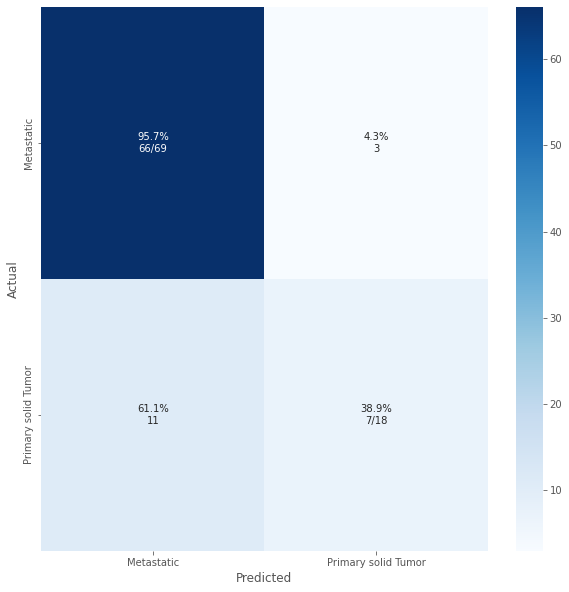

In [298]:
# importing confusion matrix to compare actual test labels vs the predicted by model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

# creating labels from the '0' and '1' binary labels for easier display
y_test_labels = np.where(y_test, 'Primary solid Tumor', 'Metastatic')
logreg_pred_labels = np.where(logreg_predicted, 'Primary solid Tumor', 'Metastatic')

def plot_cm(y_true, y_pred, figsize=(10,10)):
    """
        Plot for the confusion matrix taking in the labels for the real values and predicted
    """
    
    # implementing the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test_labels, logreg_pred_labels)
plt.savefig('logreg_untuned_conmatrix.png')

# releasing memory allocation
del logreg_pred_labels

Running PCA before modeling

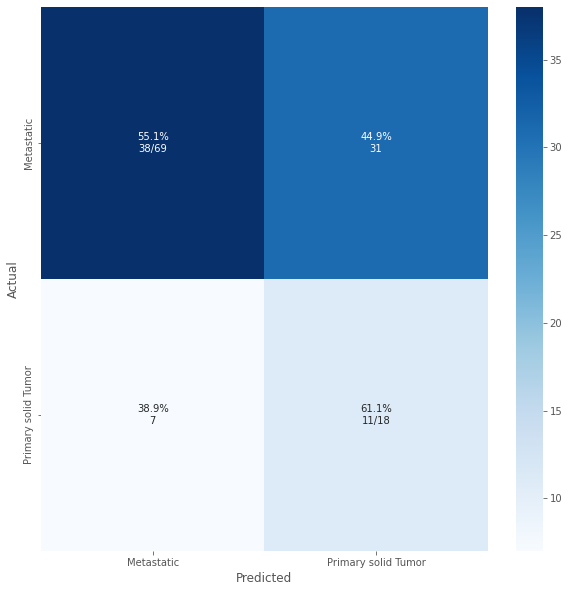

In [299]:
# importing PCA from sklearn
from sklearn.decomposition import PCA

# implementing PCA
pca = PCA(n_components=2) #assume to keep 2 components, but doesn't matter
pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
pca_X_test = pd.DataFrame(pca.transform(X_test))

# model instanciation, changing the class_weight hyperparameter to account for unbalanced classes
lrpca_cls = LogisticRegression(class_weight='balanced') 
# training model
lrpca_cls.fit(pca_X_train, y_train)

# making predictions 
lr_pca_pred = lrpca_cls.predict(pca_X_test)

lrpca_pred_labels = np.where(lr_pca_pred, 'Primary solid Tumor', 'Metastatic')

# viz for confusion matrix
plot_cm(y_test_labels, lrpca_pred_labels)
plt.savefig('logreg_tuned_conmatrix.png')
# releasing memory
del lrpca_pred_labels

In [300]:
# calling in the matrics function to check how well our predictions did
from sklearn import metrics

print(metrics.classification_report(lr_pca_pred, y_test))
print("Accuracy: %3f" % (np.mean(lr_pca_pred == y_test)))

              precision    recall  f1-score   support

           0       0.55      0.84      0.67        45
           1       0.61      0.26      0.37        42

    accuracy                           0.56        87
   macro avg       0.58      0.55      0.52        87
weighted avg       0.58      0.56      0.52        87

Accuracy: 0.563218


Plot variance by PC#

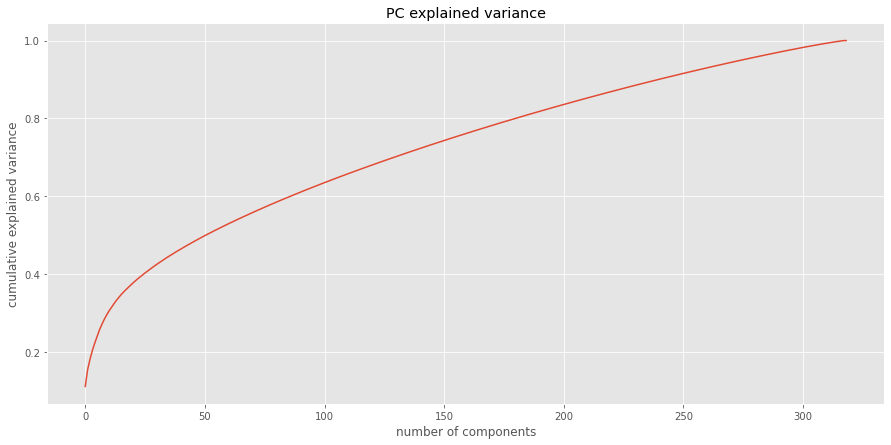

In [245]:
# doing PCA to check how many PCs are good enough to explain variance
pca = PCA().fit(X_train)

# setting figure parameters for size
fig_dims = (15, 7)
fig, ax = plt.subplots(1,1,figsize=fig_dims)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PC explained variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('PCA_explained_variance.png')

Obviously a super high dim dataset!

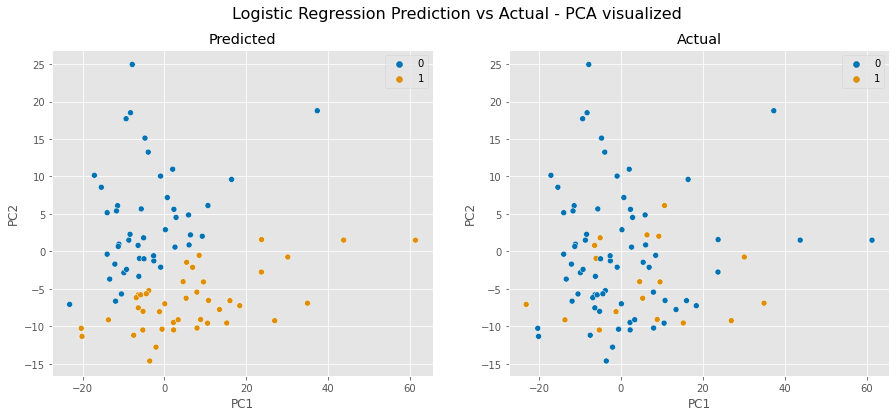

<Figure size 432x288 with 0 Axes>

In [301]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(1,2,figsize=fig_dims)
# Data for a axis from PCs
xline = pca_X_test.iloc[:, 0]
yline = pca_X_test.iloc[:, 1]
# plotting
sns.scatterplot(x=xline, y=yline,hue=lr_pca_pred, cmap='colorblind', ax=ax[0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=yline,hue=np.array(y_test), cmap='colorblind', ax=ax[1], palette='colorblind', legend='full')

ax[0].set_title("Predicted")
ax[1].set_title("Actual")
ax[0].set(xlabel="PC1", ylabel="PC2")
ax[1].set(xlabel="PC1", ylabel="PC2")

fig.suptitle('Logistic Regression Prediction vs Actual - PCA visualized', fontsize=16)
plt.legend(loc='upper right')
plt.show()
plt.savefig('logreg_separation_PCA.png')

Rerunning with 25 PCs increases accuracy to semi-reasonable value 

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        62
           1       0.67      0.48      0.56        25

    accuracy                           0.78        87
   macro avg       0.74      0.69      0.71        87
weighted avg       0.77      0.78      0.77        87

Accuracy: 0.781609


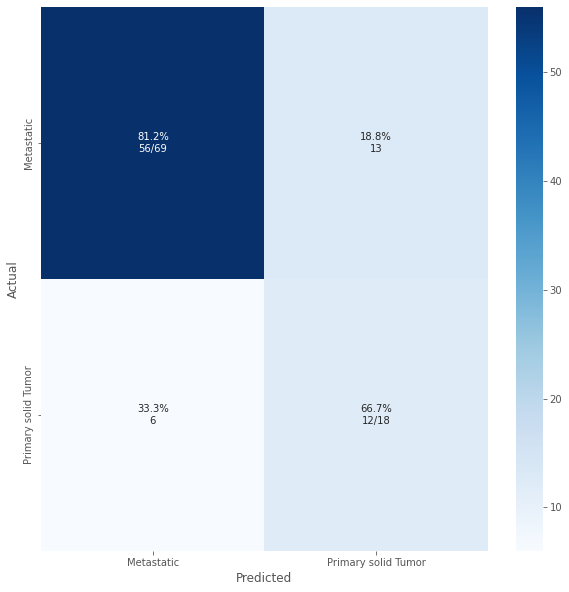

In [302]:
# Rerunning the PCA procedure
pca = PCA(n_components=25) #change to 25 components
newdf_train = pca.fit_transform(X_train)
newdf_valid = pca.transform(X_test)

features_train = pd.DataFrame(newdf_train)
features_valid = pd.DataFrame(newdf_valid)  
del newdf_train, newdf_valid

lrpca_cls = LogisticRegression(class_weight='balanced') 
lrpca_cls.fit(features_train, y_train)
lr_pca_pred = lrpca_cls.predict(features_valid)

lrpca_pred_labels = np.where(lr_pca_pred, 'Primary solid Tumor', 'Metastatic')

plot_cm(y_test_labels, lrpca_pred_labels)
plt.savefig('logreg_tuned_conmatrix.png')
print(metrics.classification_report(lr_pca_pred, y_test))
print("Accuracy: %3f" % (np.mean(lr_pca_pred == y_test)))


Trying a decision tree - 79.8% accuracy isn't horrid considering there are only ~30 primary solid tumor samples to learn from! 

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        65
           1       0.61      0.50      0.55        22

    accuracy                           0.79        87
   macro avg       0.73      0.70      0.71        87
weighted avg       0.78      0.79      0.79        87

Accuracy: 0.793103


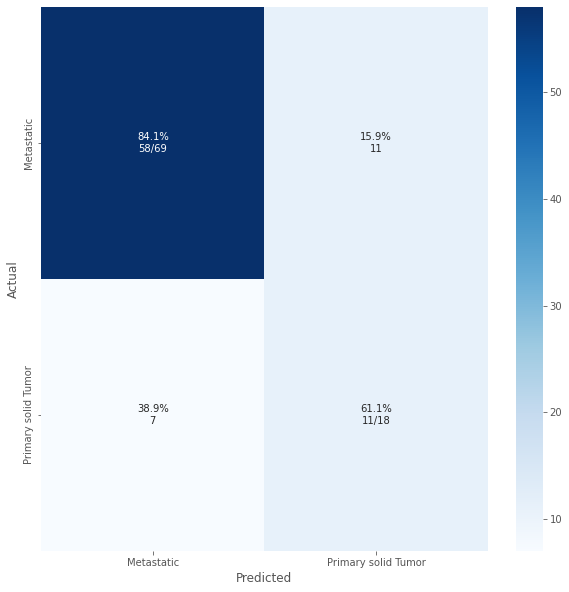

In [303]:
# importing the decision tree classifier model
from sklearn.tree import DecisionTreeClassifier
#create instance of model
dtc_model = DecisionTreeClassifier()
# fit the model on train data
dtc_model.fit(X_train, y_train)
# make prediction
dtc_pred = dtc_model.predict(X_test)

# labels for vizual
dtc_pred_labels = np.where(dtc_pred, 'Primary solid Tumor', 'Metastatic')

# display results
plot_cm(y_test_labels, dtc_pred_labels)
plt.savefig('dTree_conmatrix.png')
print(metrics.classification_report(dtc_pred, y_test))
print("Accuracy: %3f" % ( np.mean(y_test==dtc_pred)))

Accessing feature importance - which genes are most predictive of metastatic/primary tumor ID

Gene #16644 is most predictive - worth following up on. 

,gene,coef
0,0,0.000000
38194,38194,0.000000
38195,38195,0.000000
38196,38196,0.000000
38197,38197,0.000000
...,...,...
1777,1777,0.046157
43827,43827,0.063927
46782,46782,0.067833
4114,4114,0.157005


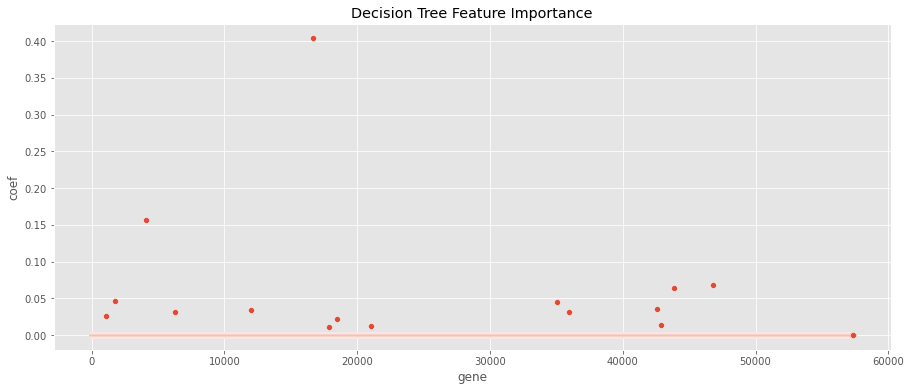

In [307]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(1,1,figsize=fig_dims)

d2 = pd.DataFrame(dtc_model.feature_importances_.T).reset_index()
d2.columns = ['gene', 'coef']
sns.scatterplot(y='coef',x='gene',data=d2)
plt.title('Decision Tree Feature Importance')
plt.savefig('dTree_feature_importance.png')

d2.sort_values('coef')

Random forest model

In [308]:
# first we make the labels into factors 
Y = pd.factorize(data['definition'])[0]
# Now we pass to create train test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.4, random_state=42)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,

In [309]:
# Import the model
from sklearn.ensemble import RandomForestClassifier

# instanciate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
# fit or train the model
rf_model.fit(X_train, y_train)
# make predictions
rf_pred = rf_model.predict(X_test)

# calculate metrics to see how well our model performed
print(metrics.classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.46      0.89      0.61        19
           1       0.99      0.87      0.92       155

    accuracy                           0.87       174
   macro avg       0.72      0.88      0.77       174
weighted avg       0.93      0.87      0.89       174



Getting better! 

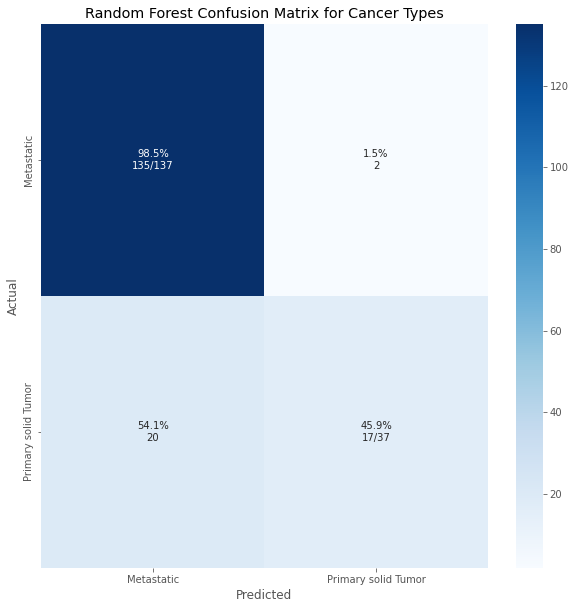

In [310]:
# Creating labels for the cancer type predictions from the numbers back to labels
cond_test = [ y_test == 0, y_test == 1]
cond_pred = [ rf_pred == 0, rf_pred == 1]
choices = [ 'Primary solid Tumor', 'Metastatic' ]
rf_test_labels = np.select(cond_test, choices, default=np.nan)
rf_pred_labels = np.select(cond_pred, choices, default=np.nan)

plot_cm(rf_test_labels, rf_pred_labels)
plt.title('Random Forest Confusion Matrix for Cancer Types')
plt.savefig('rForest_conmatrix.png')

In [311]:
# implementing PCA
pca = PCA(n_components=3) 
pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
pca_X_test = pd.DataFrame(pca.transform(X_test))

In [312]:
def visualize_classifier(model, X, y,X_test, y_test, ax=None):
    """
        Creates a visualization grid space for the areas a data point fall into
    """
    ax = ax or plt.gca()
    # Plot the training points
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, cmap='rainbow', edgecolors= "black",
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow')
    
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)

    ax.set(xlim=xlim, ylim=ylim)

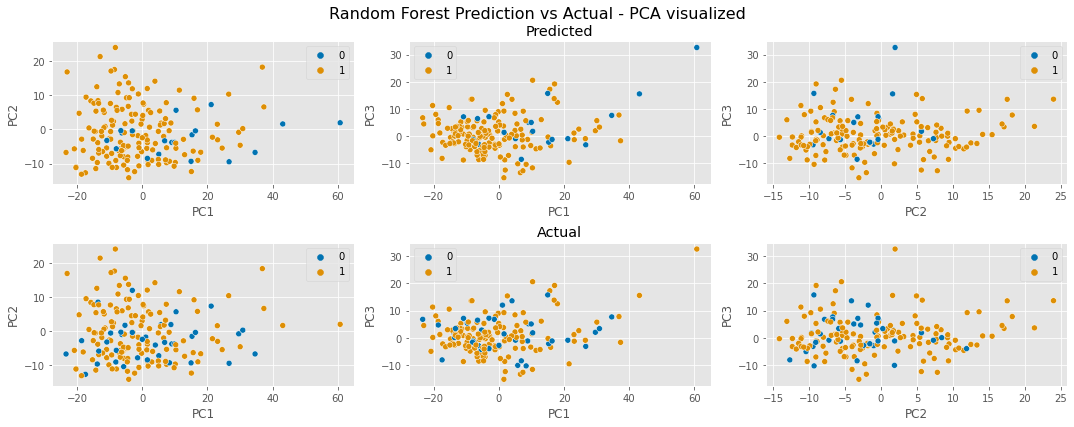

In [313]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(2,3,figsize=fig_dims)
# Data for a axis from PCs
xline = pca_X_test.iloc[:, 0]
yline = pca_X_test.iloc[:, 1]
zline = pca_X_test.iloc[:, 2]
# plotting predicted
sns.scatterplot(x=xline, y=yline,hue=rf_pred, cmap='colorblind', ax=ax[0,0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=zline,hue=rf_pred, cmap='colorblind', ax=ax[0,1], palette='colorblind')
sns.scatterplot(x=yline, y=zline,hue=rf_pred, cmap='colorblind', ax=ax[0,2], palette='colorblind')

# plotting actual
sns.scatterplot(x=xline, y=yline,hue=np.array(y_test), cmap='colorblind', ax=ax[1,0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=zline,hue=np.array(y_test), cmap='colorblind', ax=ax[1,1], palette='colorblind')
sns.scatterplot(x=yline, y=zline,hue=np.array(y_test), cmap='colorblind', ax=ax[1,2], palette='colorblind')


ax[0,1].set_title("Predicted")
ax[1,1].set_title("Actual")
ax[0,0].set(xlabel="PC1", ylabel="PC2")
ax[0,1].set(xlabel="PC1", ylabel="PC3")
ax[0,2].set(xlabel="PC2", ylabel="PC3")
ax[1,0].set(xlabel="PC1", ylabel="PC2")
ax[1,1].set(xlabel="PC1", ylabel="PC3")
ax[1,2].set(xlabel="PC2", ylabel="PC3")
plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)


fig.suptitle('Random Forest Prediction vs Actual - PCA visualized', fontsize=16)
plt.savefig('rForest_separation_PCA.png')
plt.show()

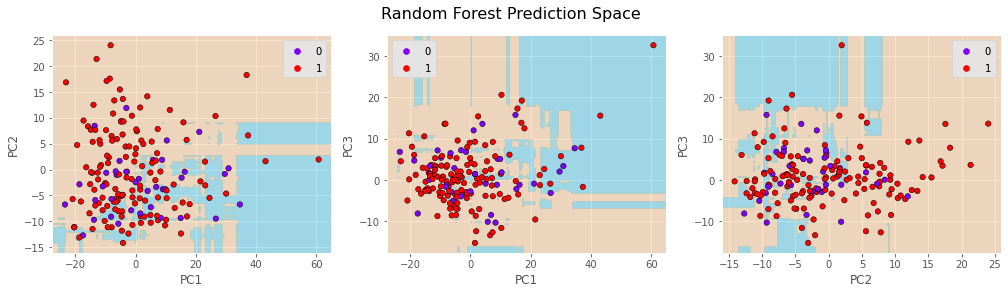

In [314]:
# setting figure parameters for size
fig_dims = (17, 4)
fig, ax = plt.subplots(1,3,figsize=fig_dims)
visualize_classifier(rf_model, np.array(pca_X_train)[:,:2], y_train,np.array(pca_X_test)[:,:2], y_test,ax=ax[0])
visualize_classifier(rf_model, np.array(pca_X_train)[:,[0,2]], y_train,np.array(pca_X_test)[:,[0,2]], y_test,ax=ax[1])
visualize_classifier(rf_model, np.array(pca_X_train)[:,1:], y_train,np.array(pca_X_test)[:,1:], y_test,ax=ax[2])

ax[0].set(xlabel="PC1", ylabel="PC2")
ax[1].set(xlabel="PC1", ylabel="PC3")
ax[2].set(xlabel="PC2", ylabel="PC3")

fig.suptitle('Random Forest Prediction Space', fontsize=16)
plt.savefig('rForest_Decision_space.png')
plt.show()

Last model - trying a SVM

In [315]:
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=100, svd_solver='randomized', whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Set up grid search 

In [316]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0001, 0.0005, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: user 6min 2s, sys: 4min 55s, total: 10min 58s
Wall time: 1min 35s
{'svc__C': 10, 'svc__gamma': 0.0005}


In [317]:
# setting best model from grid search parameters
svc_model = grid.best_estimator_
# predicting on test values
svc_pred = svc_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        40
           1       0.89      0.91      0.90       134

    accuracy                           0.84       174
   macro avg       0.78      0.77      0.77       174
weighted avg       0.84      0.84      0.84       174



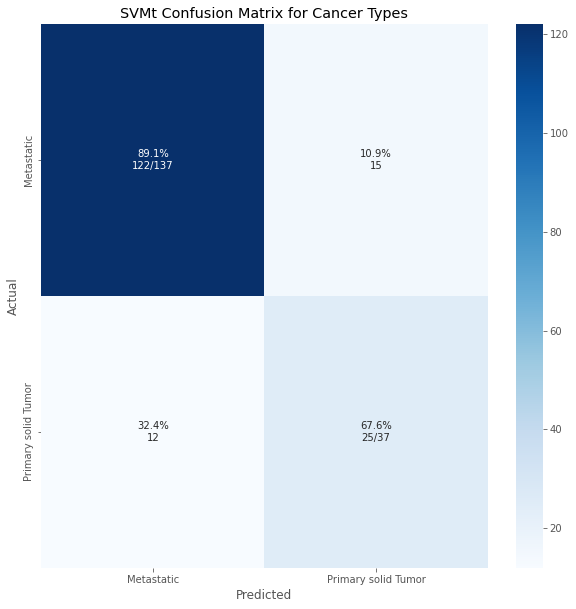

In [318]:
cond_test = [ y_test == 0, y_test == 1]
cond_pred = [ svc_pred == 0, svc_pred == 1 ]
choices = [ 'Primary solid Tumor', 'Metastatic']
svc_test_labels = np.select(cond_test, choices, default=np.nan)
svc_pred_labels = np.select(cond_pred, choices, default=np.nan)

print(metrics.classification_report(svc_pred, y_test))
plot_cm(svc_test_labels, svc_pred_labels)
plt.title('SVMt Confusion Matrix for Cancer Types')
plt.savefig('SVM_conmatrix.png')